# SVR training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sklearn as sk
import sklearn.metrics
import sklearn.model_selection 
import sklearn.svm

In [2]:
# constants
PARA_JOBS = 8
NUM_SEARCH_PARAMS = 10

In [3]:
def custom_huber_loss(y_true, y_pred): # as implemented in https://github.com/astroML/astroML
    delta = 1.0
    t = abs((y_true - y_pred))
    flag = t > delta
    ave=np.mean(np.array(y_true))
    return - (np.sum((~flag) * (0.5 * t * t) + (flag) * delta * (t - 0.5 * delta))
        /np.sum(0.5*(y_true-ave)*(y_true-ave)))

In [4]:
# read training and test dataset
[X_trainvalid, X_test, y_trainvalid, y_test] = pickle.load(open('./dataset/raw_data.pickle', 'rb'))

In [5]:
# read full dataset
store = pd.HDFStore('./dataset/data_train.h5')
df_dataset = store['df_all']
store.close()

In [6]:
# train model
huber_score=sklearn.metrics.make_scorer(custom_huber_loss, greater_is_better=True)
params = {'C':np.logspace(-2,3,NUM_SEARCH_PARAMS), 'epsilon':np.logspace(-3,2,NUM_SEARCH_PARAMS)}

grid_search = sk.model_selection.GridSearchCV(sk.svm.SVR(),params, cv=5, scoring=huber_score,
                                              return_train_score=True, n_jobs=PARA_JOBS, verbose=0)
grid_search.fit(X_trainvalid, y_trainvalid)
model = sk.svm.SVR(**grid_search.best_params_)
model.fit(X_trainvalid, y_trainvalid)
print('best hyperparameters')
print(grid_search.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


best hyperparameters
{'C': 1000.0, 'epsilon': 0.046415888336127795}


In [7]:
# predict
pred_trainvalid = model.predict(X_trainvalid)
pred_test = model.predict(X_test)

In [8]:
# create DataFrame for analyses
df_temp=pd.DataFrame(pred_test, index=X_test.index, columns=['pred_svr'])
df_dataset_pred_test = pd.concat([df_temp, df_dataset], axis=1, join_axes=[df_temp.index])
df_dataset_pred_test['ml_error'] = df_dataset_pred_test['pred_svr']-df_dataset_pred_test['PG18PI17_e_electronic_ave']

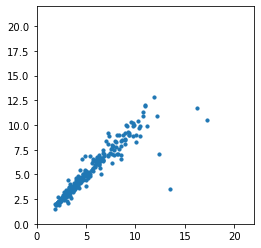

In [9]:
# Fig 1
plt.xlim([0,22])
plt.ylim([0,22])
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(df_dataset_pred_test['PG18PI17_e_electronic_ave'],df_dataset_pred_test['pred_svr'], s=10)

In [10]:
# Table II
fs = [sk.metrics.r2_score, sk.metrics.mean_absolute_error,
     sk.metrics.mean_squared_error, 
     lambda y1,y2: np.sqrt(abs(sk.metrics.mean_squared_error(y1,y2)))]
pd.DataFrame([[f(x[0],x[1]) for x in 
            [[y_trainvalid, pred_trainvalid],[y_test, pred_test]]]
           for f in fs], index=['$r^2$','MAE','MSE','RMSE'],columns=['training','test'])

,training,test
$r^2$,0.919093,0.861518
MAE,0.239890,0.436142
MSE,0.686649,0.989959
RMSE,0.828643,0.994967


In [11]:
# Table III
(df_dataset_pred_test.iloc[np.argsort(-abs(df_dataset_pred_test.ml_error)).values]
 [['MP_pretty_formula','pred_svr','PG18PI17_e_electronic_ave','ml_error','MP_e_above_hull']]
 .head(10).set_axis(
     ['formula','$ε_{SVR}$','$ε_{Dataset}$','$\Deltaε_{Dataset}$','$\Delta E_{hull}$ (meV)'],
     axis=1, inplace=False).reset_index(drop=True))

,formula,$ε_{SVR}$,$ε_{Dataset}$,$\Deltaε_{Dataset}$,$\Delta E_{hull}$ (meV)
0,LiBC,3.535632,13.527296,-9.991664,0.0
1,Ga2Te5,10.479192,17.192620,-6.713428,0.0
2,LiAsS2,7.045134,12.385101,-5.339967,0.0
3,In2HgTe4,11.688782,16.202640,-4.513858,0.0
4,KCaBi,9.221002,7.211809,2.009192,0.0
5,CdCN2,6.550195,4.593316,1.956880,0.0
6,HfNCl,6.883461,4.937166,1.946295,0.0
7,CuBS2,6.590452,8.532116,-1.941665,0.0
8,CuBSe2,8.270815,10.034238,-1.763424,0.0
9,Cu2HgI4,6.910665,8.532187,-1.621522,0.0
